In [2]:
# importing all the required modules
%matplotlib inline

import numpy as np
import pickle
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# loading the pickle file which is saved already
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_dataset']
    train_labels = pickle_data['train_labels']
    valid_features = pickle_data['valid_dataset']
    valid_labels = pickle_data['valid_labels']
    test_features = pickle_data['test_dataset']
    test_labels = pickle_data['test_labels']
    del pickle_data
    
print('Data and modules loaded.')

Data and modules loaded.


In [9]:
# 28x28 image  = 784 pixels
feature_count = 784
# 10 letters in the dataset
label_count = 10

#creating the placeholders. Placeholder are the values we can supply on th runtime through feed dict
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# creating the weights, these are the the system tries to find
weights = tf.Variable(tf.truncated_normal((feature_count, label_count)))
biases = tf.Variable(tf.zeros(label_count))

# different feed dicts 
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# the linear function
logits = tf.matmul(features, weights) + biases

# softmax: convert logits to probablities
prediction = tf.nn.softmax(logits)

# distance from the labels and predictions
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), axis=1)

# loss is average cross entropy
loss = tf.reduce_mean(cross_entropy)

# global varialble initializer
init = tf.global_variables_initializer()

# testing
with tf.Session() as session:
    session.run(init)
    a = session.run(loss, feed_dict = train_feed_dict)
    b = session.run(loss, feed_dict = valid_feed_dict)
    c = session.run(loss, feed_dict = test_feed_dict)
    biases_data = session.run(biases)

In [10]:
print(a)
print(b)
print(c)
print(biases_data)

16.6404
16.8846
16.7245
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [15]:
# maps to get accuracy
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

Epoch  4/4: 100%|██████████| 2850/2850 [00:23<00:00, 120.62batches/s]


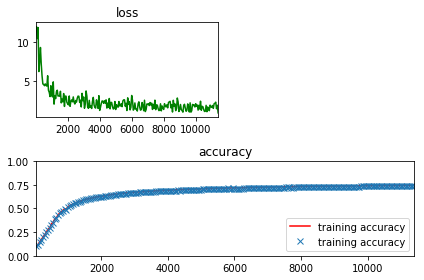

In [20]:
# real training

epochs = 4
batch_size = 50
learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy with map plot lib
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# the actual session
with tf.Session() as session:
    session.run(init)
    # we are learning the data in batches of 50 items each. So number of batches will be no by batch size
    batch_count = int(math.ceil(len(train_features)/batch_size))
    
    # looping epoch number of times
    for epoch_i in range(epochs):
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels in groups of 50
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            
            o,l = session.run([optimizer, loss], feed_dict={features:batch_features, labels:batch_labels})
            
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(221)
loss_plot.set_title("loss")
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim(batches[0], batches[-1])

acc_plot = plt.subplot(212)
acc_plot.set_title('accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='training accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='training accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()